In [1]:
%matplotlib inline
import numpy as np
import pylab
import seaborn

In [2]:
class RuBisCOParams(object):
    def __init__(self, vmax_c, km_c, km_o, S, V):
        """
        Args:
            vmax_c: units uM/s.
            km_c: units uM.
            km_o: units uM.
            S: unitless.
            V: microliters, volume rubisco encapsulated in.
        
        Specificity factor S is defined as
            S = vmax_c * km_o / (vmax_o * km_c)
        When the enzyme is in the linear regime for both
        substrates,
            S = vc * [o2] / (vo * [co2])
        """
        self.vmax_c = vmax_c
        self.km_c = km_c
        self.km_o = km_o
        self.S = S
        self.vmax_o = vmax_c * km_o / (km_c * S)
        self.V = V

    def vs(self, co2, o2):
        """Concentrations in micromolar.
        """
        vc = (self.V * self.vmax_c) / (1.0 + (self.km_c / co2) + (self.km_c * o2 / (self.km_o * co2)))
        vo = (self.V * self.vmax_o) / (1.0 + (self.km_o / o2) + (self.km_o * co2 / (self.km_c * o2)))
        return vc, vo
    
    def cost(self, co2, o2):
        vc, vo = self.vs(co2, o2)
        return (32 * vc + 40 * vo) / vc

In [3]:
vol_cell = 5.2360e-10  # microliters
vol_csome = 5.2360e-13 # microliters

Rub_cbsome = RuBisCOParams(vmax_c=7.3578e+04,
                           km_c=276.9778,
                           km_o=791.8306,
                           S=43, 
                           V=vol_csome)
Rub_cyto = RuBisCOParams(vmax_c=6.8,
                         km_c=2.6,
                         km_o=304.0,
                         S=166,
                         V=vol_cell)

# Extracellular CO2 concentration ranges from 1 uM to 1 mM
# which is 10x below ambient (15 mM) and 100 above.
co2_ext = np.logspace(0, 3, 40) # uM
# Assume that CCM achieves 30 mM HCO3- regardless of extracellular [CO2]
hco3_in_ccm = 3e4 # uM
# O2 is always ambient, 300 uM
o2_ext = 300 # uM

# Intracellular pH assumed to be 8, which is approximately optimal
# for the full model of the CCM.

# In this simplified model a lower pH would increase the rate of fixation
# because it would increase the CO2 supply at RuBisCO. However, this 
# simplified case neglects transport required to achieve 30 mM HCO3- 
# which is greatly diminished by increased pH. FYI
pH_in = 8.0

# Assumptions:
# * CCM can set cytosolic [HCO3-] = 30 mM at no cost.
# * Carboxysomal RuBisCO sees [CO2] that is roughly in equilibrium
#   with the 30 mM [HCO3-] given the pH, using pKa = 6.2
# * Cytoplasmic RuBisCO sees extracellular CO2 concentrations
# * In both cases, O2 at RuBisCO is ambient.
pKs = np.arange(6.1, 6.3, 0.1)
co2_in_ccm = hco3_in_ccm / (10**(pH_in - pKs))
cost_ccm = Rub_cbsome.cost(co2_in_ccm, o2_ext)
cost_cyto = Rub_cyto.cost(co2_ext, o2_ext)

co2_equal = co2_ext[np.where(cost_cyto <= cost_ccm[2])][0]

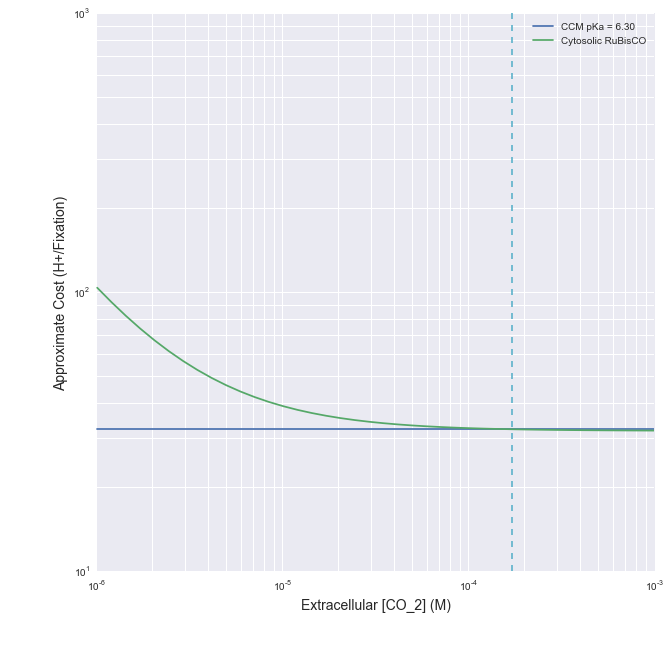

In [4]:
pylab.figure(figsize=(10,10))
palette = seaborn.color_palette()
pylab.yscale('log')
pylab.xscale('log')
pylab.plot(co2_ext * 1e-6, np.ones(co2_ext.size) * cost_ccm[2],
           label='CCM pKa = %.2f' % pKs[2])
pylab.plot(co2_ext * 1e-6, cost_cyto, label='Cytosolic RuBisCO')
pylab.axvline(co2_equal * 1e-6, ls='--', color=palette[-1])
pylab.xlabel('Extracellular [CO_2] (M)', fontsize=14)
pylab.ylabel('Approximate Cost (H+/Fixation)', fontsize=14)
pylab.legend()
pylab.xlim(1e-6, 1e-3)
pylab.show()